In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np

import quantem as em
from quantem.core import config
from quantem.core.datastructures import Dataset4dstem
from quantem.diffractive_imaging.dataset_models import PtychographyDatasetRaster
from quantem.diffractive_imaging.pftm import PFTM, PFTM_DIP
from quantem.core.visualization import show_2d

config.set_device(0)
print(config.get("device"))


/home/amccray/code/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
file_data = Path("~/code/quantem-tutorials/data/ducky_clean.zip").expanduser()
dset: Dataset4dstem = em.io.load(file_data)
print(dset)

quantem Dataset named 'ducky'
  shape: (25, 25, 128, 128)
  dtype: uint16
  device: cpu
  origin: [0. 0. 0. 0.]
  sampling: [5.    5.    0.025 0.025]
  units: ['A', 'A', 'A^-1', 'A^-1']
  signal units: 'arb. units'


Calculated best fit rotation = 0 degrees.


Normalizing intensities: 100%|██████████| 625/625 [00:00<00:00, 1326.85probe position/s]


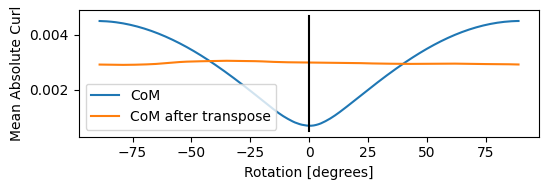

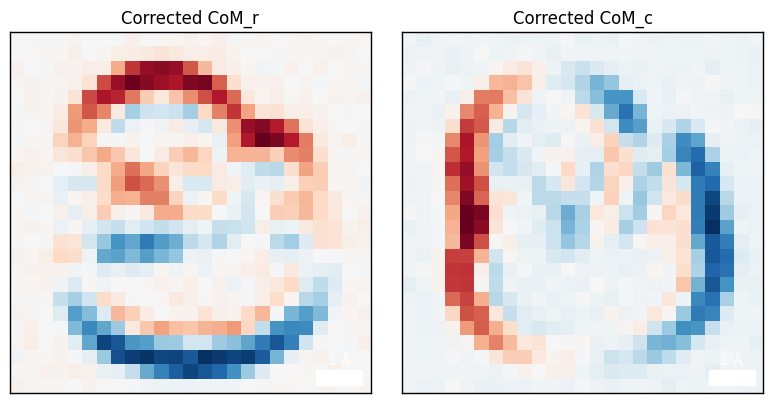

In [4]:
pdset = PtychographyDatasetRaster.from_dataset4dstem(dset)

pdset.preprocess(
    com_fit_function="constant",
    plot_rotation=True,
    plot_com=True,
)

In [5]:
pftm_pix = PFTM.from_dataset(
    dset=pdset,
    num_slices=1,
    obj_type="pure_phase",
    num_probes=1,
    energy=80e3,
    defocus=500,
    semiangle_cutoff=20,
    obj_padding_px=(32,32),
)

Epoch 100/100, Loss: 1.427e+00: 100%|██████████| 100/100 [00:04<00:00, 23.52it/s]


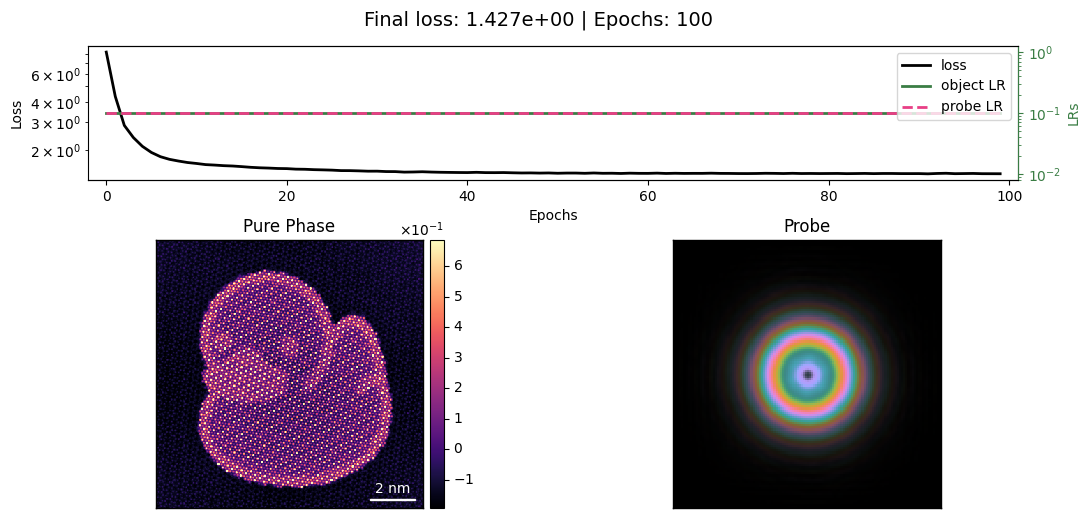

In [6]:
pftm_pix.reconstruct(num_iter=100, device="gpu", batch_size=128).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'pixelated'}>, <Axes: >],
       dtype=object))

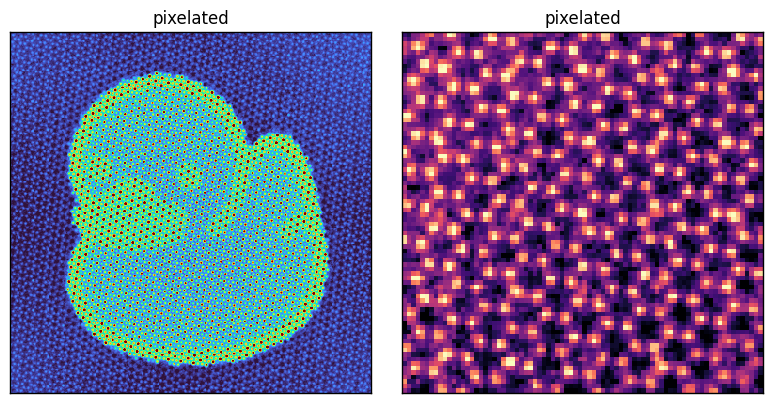

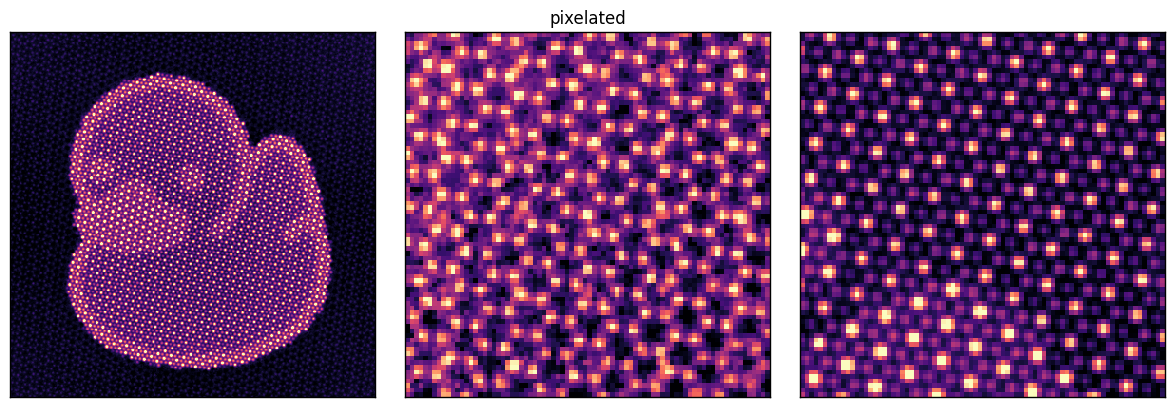

In [7]:
show_2d(
    [np.angle(pftm_pix.obj_cropped[0]), np.angle(pftm_pix.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title='pixelated',
)
show_2d(
    [
        np.angle(pftm_pix.obj_cropped[0]),
        np.angle(pftm_pix.obj_cropped[0, :80, :80]),
        np.angle(pftm_pix.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=['', 'pixelated', ''],
)

## DIP

Epoch 50/50, Loss: 2.108e-03, : 100%|██████████| 50/50 [00:01<00:00, 35.58it/s]


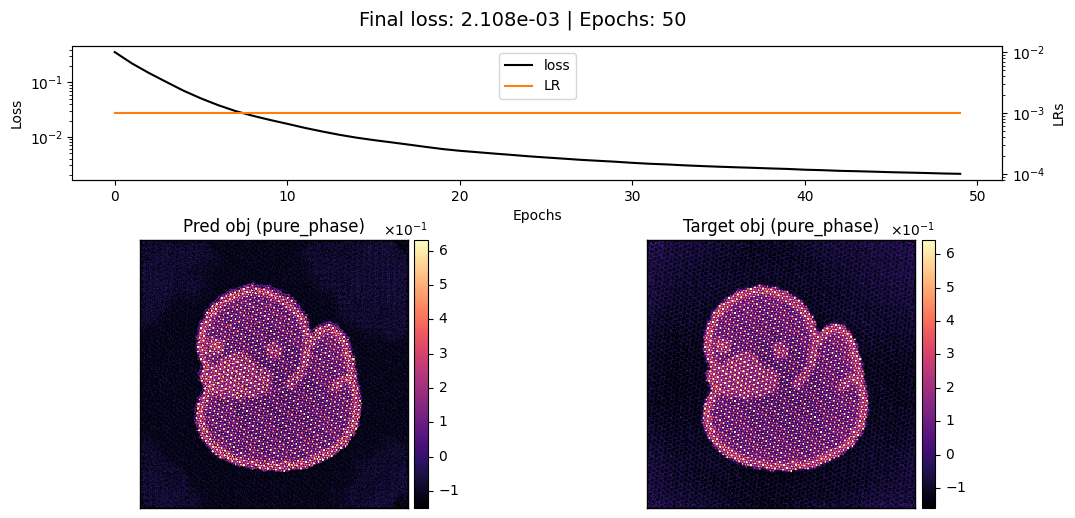

Epoch 50/50, Loss: 1.458e+00, : 100%|██████████| 50/50 [00:01<00:00, 33.89it/s]


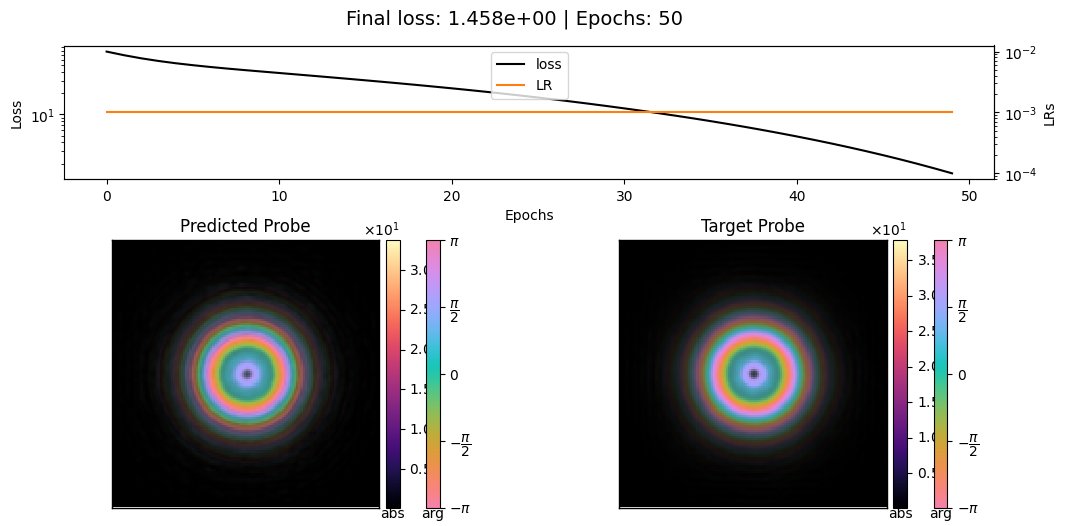

In [8]:
pftm_dip = PFTM_DIP.from_pftm(
    pftm_pix,
    pretrain_iters=50,
    device='gpu', 
)

Epoch 25/25, Loss: 1.563e+00: 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


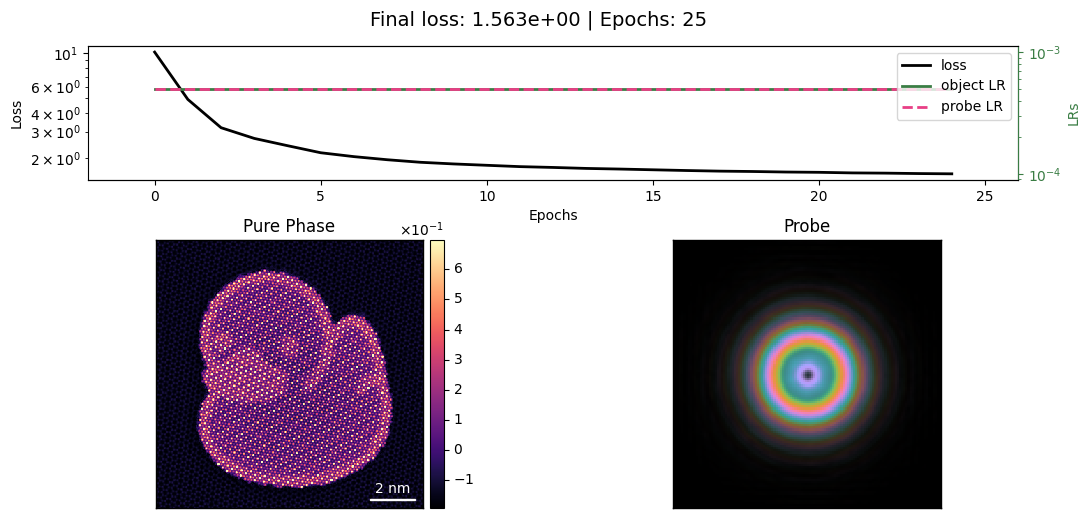

In [9]:
pftm_dip.reconstruct(num_iter=25, reset=True, scheduler_type='plateau', batch_size=128).visualize()

Epoch 100/100, Loss: 1.420e+00: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


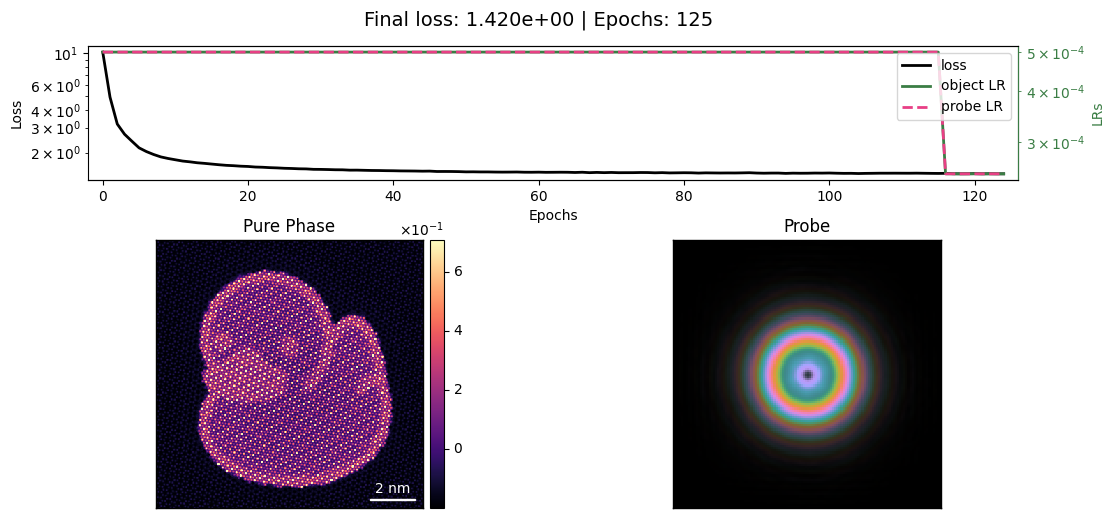

In [10]:
pftm_dip.reconstruct(num_iter=100).visualize()

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'dip'}>, <Axes: >], dtype=object))

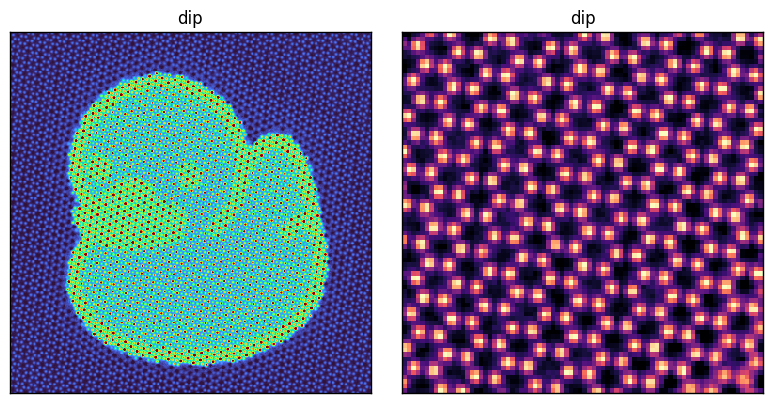

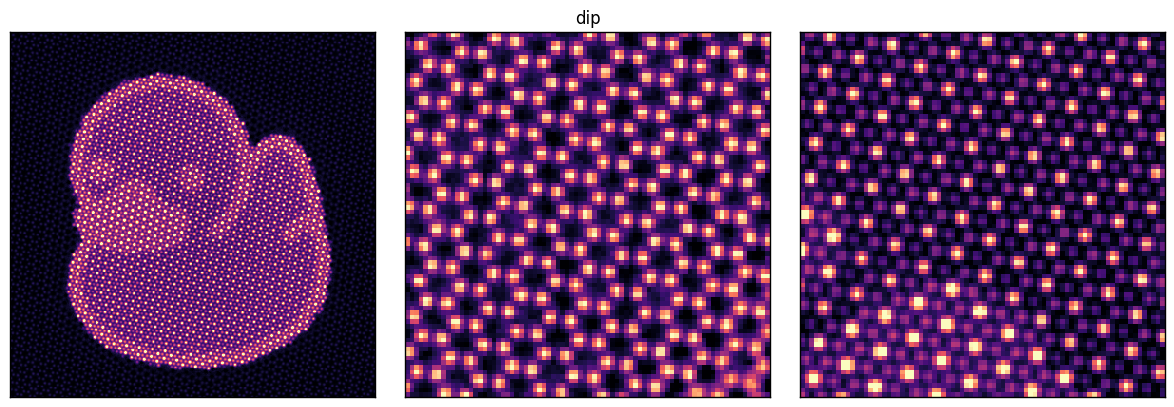

In [11]:
show_2d(
    [np.angle(pftm_dip.obj_cropped[0]), np.angle(pftm_dip.obj_cropped[0, :80, :80])],
    cmap=["turbo", "magma"],
    title='dip',
)
show_2d(
    [
        np.angle(pftm_dip.obj_cropped[0]),
        np.angle(pftm_dip.obj_cropped[0, :80, :80]),
        np.angle(pftm_dip.obj_cropped[0, 100:180, 100:180]),
    ],
    cmap="magma",
    title=['', 'dip', ''],
)